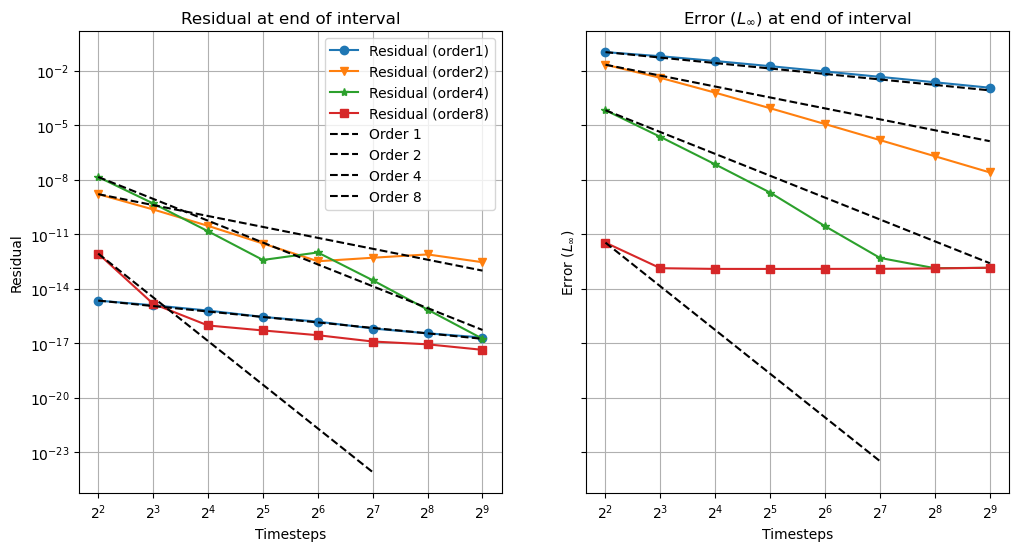

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

mesh_type = "RECTANGLE_2x1" # "UNIT_SQUARE" or "RECTANGLE_2x1"
equation = "POLY_N"
orders = ["order1", "order2", "order4", "order8"]

print_full_stats = False
convergence_analysis = True

if print_full_stats:
    for order in orders:
        data_dir = f"data/{mesh_type}/{equation}/{order}"
        full_stats_files = os.listdir(data_dir + "/statistics")
        for file in full_stats_files:
            if file.endswith(".csv"):
                df = pd.read_csv(f"{data_dir}/statistics/{file}")
                print(df)
                
if convergence_analysis:
    residual_df = pd.DataFrame()
    error_df = pd.DataFrame()
    for order in orders:
        file_path = f"data/{mesh_type}/{equation}/{order}/convergence_data.csv"
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            orders.remove(order)
            continue
        
        df.rename(columns={"error": f"error_{order}", "residual": f"residual_{order}"}, inplace=True)
        
        if residual_df.empty:
            residual_df.insert(0, "timesteps", df["timesteps"])
            
        if error_df.empty:
            error_df.insert(0, "timesteps", df["timesteps"])
        
        residual_df.insert(len(residual_df.columns), f"Residual ({order})", df["final_residual"])
        error_df.insert(len(error_df.columns), f"Error ({order})", df["final_error"])



    # Plotting the convergence data

    fig, (residual_ax, error_ax) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)
    markers = ["o", "v", "*", "s", "D", "^", "1"]

    for index, order in enumerate(orders):
        residual_ax.plot(
                "timesteps",
                f"Residual ({order})",
                data=residual_df,
                marker=markers[index],
                )
        error_ax.plot(
                "timesteps",
                f"Error ({order})",
                data=error_df,
                marker=markers[index],
                )
    
    # Plot reference lines of order 1, 2, 4, 8
    residual_ax.plot(residual_df["timesteps"], 4 * residual_df["Residual (order1)"][0]/residual_df["timesteps"], label="Order 1", linestyle="--", color="black")
    residual_ax.plot(residual_df["timesteps"], 4**2 * residual_df["Residual (order2)"][0]/(residual_df["timesteps"]**2), label="Order 2", linestyle="--", color="black")
    residual_ax.plot(residual_df["timesteps"], 4**4 * residual_df["Residual (order4)"][0]/(residual_df["timesteps"]**4), label="Order 4", linestyle="--", color="black")
    residual_ax.plot(residual_df["timesteps"], 4**8 * residual_df["Residual (order8)"][0]/(residual_df["timesteps"]**8), label="Order 8", linestyle="--", color="black")
    
    error_ax.plot(error_df["timesteps"], 4 * error_df["Error (order1)"][0]/error_df["timesteps"], label="Order 1", linestyle="--", color="black")
    error_ax.plot(error_df["timesteps"], 4**2 * error_df["Error (order2)"][0]/(error_df["timesteps"]**2), label="Order 2", linestyle="--", color="black")
    error_ax.plot(error_df["timesteps"], 4**4 * error_df["Error (order4)"][0]/(error_df["timesteps"]**4), label="Order 4", linestyle="--", color="black")
    error_ax.plot(error_df["timesteps"], 4**8 * error_df["Error (order8)"][0]/(error_df["timesteps"]**8), label="Order 8", linestyle="--", color="black")

    residual_ax.set_title("Residual at end of interval")
    residual_ax.set_ylabel("Residual")
    error_ax.set_title("Error ($L_\infty$) at end of interval")
    error_ax.set_ylabel("Error ($L_\infty$)")
    for ax in [residual_ax, error_ax]:           
        ax.set_xscale("log", base=2)
        ax.set_yscale("log", base=10)
        ax.set_xlabel("Timesteps")
        ax.grid(True)

    #box = residual_ax.get_position()
    #residual_ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    residual_ax.legend()

